### Funcion: get_features_cat_classification

Esta función recibe como argumentos un dataframe, el nombre de una de las columnas del mismo (argumento 'target_col'), que debería ser el target de un hipotético modelo de clasificación, es decir debe ser una variable categórica o numérica discreta pero con baja cardinalidad, un argumento "normalize" con valor False por defecto, una variable float "mi_threshold" cuyo valor por defecto será 0.

* En caso de que "normalize" sea False:
    La función debe devolver una lista con las columnas categóricas del dataframe cuyo valor de mutual information con 'target_col' iguale o supere el valor de "mi_threshold".

* En caso de que "normalize" sea True:
    La función debe devolver una lista con las columnas categóricas del dataframe cuyo valor normalizado de mutual information con 'target_col' iguale o supere el valor de "mi_threshold". El valor normalizado de mutual information se considera el obtenido de dividir el valor de mutual information tal cual ofrece sklearn o la fórmula de cálculo por la suma de todos los valores de mutual information de las features categóricas del dataframe.
    En este caso, la función debe comprobar que "mi_threshold" es un valor float entre 0 y 1, y arrojar un error si no lo es.

La función debe hacer todas las comprobaciones necesarias para no dar error como consecuecia de los valores de entrada. Es decir hará un check de los valores asignados a los argumentos de entrada y si estos no son adecuados debe retornar None y printar por pantalla la razón de este comportamiento. Ojo entre las comprobaciones debe estar que "target_col" hace referencia a una variable categórica del dataframe.

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv("./data3/titanic.csv")
df = df.drop(["age", "embark_town", "embarked", "deck"], axis=1)
target_col = "alive"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   class       891 non-null    object 
 7   who         891 non-null    object 
 8   adult_male  891 non-null    bool   
 9   alive       891 non-null    object 
 10  alone       891 non-null    bool   
dtypes: bool(2), float64(1), int64(4), object(4)
memory usage: 64.5+ KB


In [1]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

def get_features_cat_classification(df, target_col, normalize=False, mi_threshold=0):
    # Comprobar si 'target_col' es una columna del DataFrame
    if target_col not in df.columns:
        print(f"Error: '{target_col}' no es una columna válida en el DataFrame.")
        return None

    # Comprobar si 'target_col' es una variable categórica
    if not pd.api.types.is_categorical_dtype(df[target_col]) and not pd.api.types.is_object_dtype(df[target_col]):
        print(f"Error: '{target_col}' no es una variable categórica en el DataFrame.")
        return None

    # Comprobar si 'mi_threshold' es un valor float entre 0 y 1
    if not isinstance(mi_threshold, float) or mi_threshold < 0 or mi_threshold > 1:
        print("Error: 'mi_threshold' debe ser un valor float entre 0 y 1.")
        return None

    # Comprobar si 'normalize' es un booleano
    if not isinstance(normalize, bool):
        print("Error: 'normalize' debe ser un valor booleano (True/False).")
        return None

    # Copiar el DataFrame para evitar modificar el original
    df_copy = df.copy()

    # Excluir la columna objetivo antes de aplicar la codificación one-hot
    if target_col in df_copy.columns:
        df_copy.drop(columns=[target_col], inplace=True)

    # Obtener las columnas categóricas del DataFrame
    categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    # Si hay columnas categóricas no numéricas, aplicar codificación one-hot
    if categorical_cols:
        df_copy = pd.get_dummies(df_copy, columns=categorical_cols)

    # Obtener las características después de eliminar filas con valores faltantes
    X = df_copy

    # Obtener la variable objetivo después de eliminar filas con valores faltantes
    y = df[target_col].iloc[df_copy.index]

    selected_features = []

    for col in X.columns:
        # Calcula la información mutua entre la columna actual y la variable objetivo
        mi_score = mutual_info_classif(X[[col]], y)[0]

        # Si se solicita normalización, normaliza el puntaje de información mutua
        if normalize:
            mi_scores_sum = sum(mutual_info_classif(X[[col]], y) for col in X.columns)
            if mi_scores_sum == 0:
                print("Error: La suma de los puntajes de información mutua es cero, no se puede normalizar.")
                return None
            mi_score /= mi_scores_sum

        # Si el puntaje de información mutua supera el umbral especificado, agrega la columna a las seleccionadas
        if mi_score >= mi_threshold:
            selected_features.append(col)

    return selected_features

# Ejemplo de uso
# selected_features = get_features_cat_classification(df, 'alive', normalize=False, mi_threshold=0.1)
# print(selected_features)


In [9]:
get_features_cat_classification(df, target_col, normalize=True, mi_threshold=0.1)

C:\Users\adrif\AppData\Local\Temp\ipykernel_14864\4185417468.py:11: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[target_col]) and not pd.api.types.is_object_dtype(df[target_col]):


['survived']

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

def plot_cat_features(df, target_col="", columns=[], mi_threshold=0.0, normalize=False):
    # Check input values
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(target_col, str):
        raise ValueError("Input 'target_col' must be a string.")
    if not isinstance(columns, list):
        raise ValueError("Input 'columns' must be a list.")
    if not isinstance(mi_threshold, (int, float)):
        raise ValueError("Input 'mi_threshold' must be a numeric value.")
    if not isinstance(normalize, bool):
        raise ValueError("Input 'normalize' must be a boolean.")

    # If columns list is empty, set it to categorical variables of dataframe
    if not columns:
        columns = list(df.select_dtypes(include='object').columns)
    
    # Store selected categorical features
    selected_features = []
    
    # Iterate through columns
    for col in columns:
        # Calculate mutual information
        mi = mutual_info_score(df[col], df[target_col])
        
        # Check if mutual information surpasses the threshold
        if mi > mi_threshold:
            selected_features.append(col)
            # Plot distribution of labels for selected feature
            plt.figure(figsize=(10, 6))
            sns.countplot(x=col, hue=target_col, data=df, palette="Set2", dodge=True)
            plt.title(f"Distribution of {col} with respect to {target_col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.legend(title=target_col)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # If no features selected
    if not selected_features:
        print("No features selected based on mutual information threshold.")
    else:
        print("Selected features based on mutual information threshold:", selected_features)


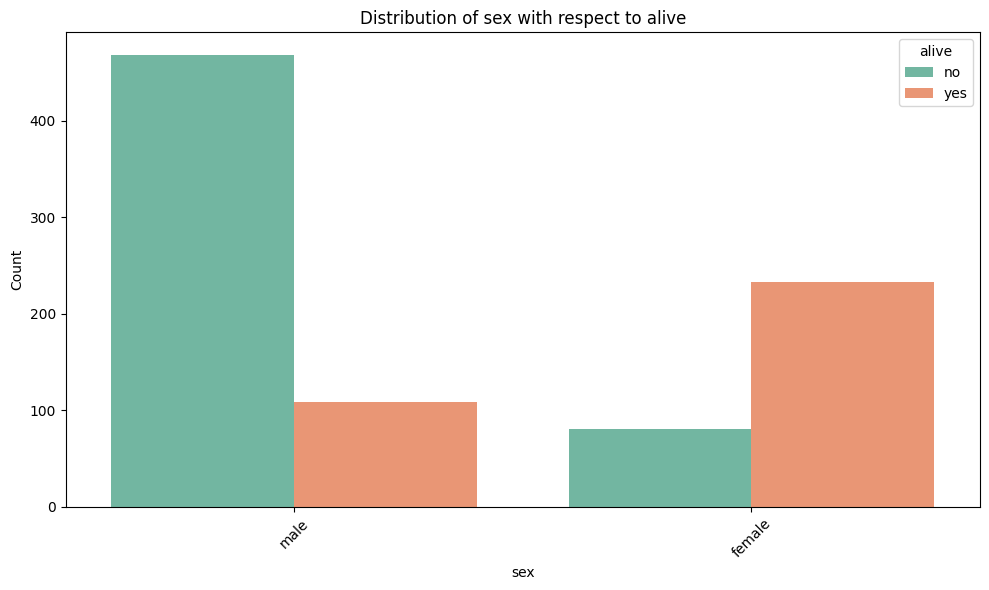

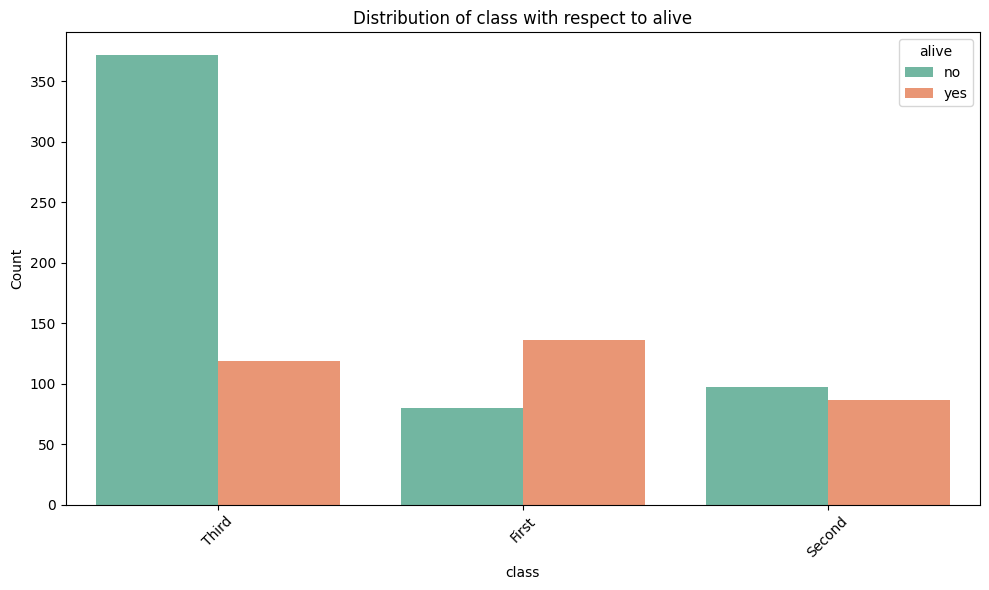

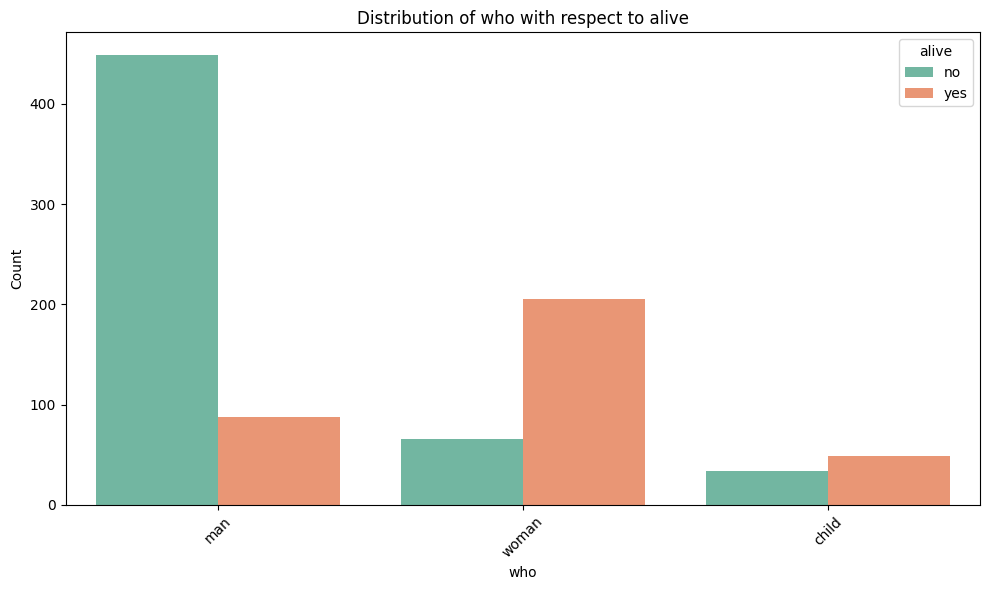

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


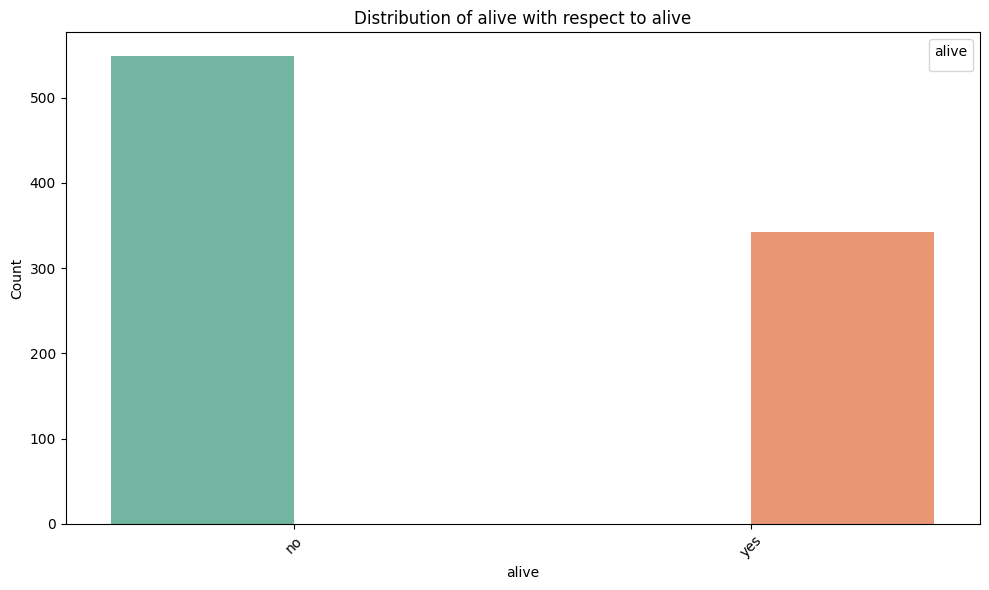

Selected features based on mutual information threshold: ['sex', 'class', 'who', 'alive']


In [5]:
plot_cat_features(df, target_col,  normalize=True,mi_threshold=0.0)